In [31]:
from PIL import Image # used for loading images
import numpy as np
import os # used for navigating to image path
import imageio # used for writing images
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import pydot
from timeit import default_timer as timer
from tensorflow.keras import backend as K
import pandas as pd

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

import sys
sys.path.append("../python/")
from helpers import *

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

"ResNet 50 dependencies"
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications import resnet50

"GoogLeNet dependencies"
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
"""Load numpy output files"""
NUM_CHANNELS = 1
SAVED_MODEL_DIR = '../../results/rn50/models/'
RESOLUTION_LIST = [64, 128, 224, 384]
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
prpo_im_224 = np.load('../../data/tidy/preprocessed_images/size224_exp5_PrPo_Im.npy', allow_pickle=True)

In [3]:
train_data, test_data = splitData(prpo_im_224, seed_num = 111)

In [4]:
input_image_shape = getImageShape(train_data, NUM_CHANNEL)

(224, 224, 1)


In [9]:
def constructRN50(image_size, scenario, num_channels = 1):
    image_shape = (image_size, image_size, num_channels)
#     p_dict = getOptCNNHyperparams(image_size, scenario)
    if scenario=="Pr_Po_Im":
        num_classes = 3
    else:
        num_classes = 2
    rn50 = resnet50.ResNet50(include_top=True, 
                           weights=None, 
                           input_tensor=None, 
                           input_shape=image_shape, 
                           pooling= 'max', 
                           classes=num_classes)
    return(rn50)

In [27]:
class Metrics(Callback):
    def __init__(self, val_data):#, batch_size = 64):
        super().__init__()
        self.validation_data = val_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal = self.validation_data
        val_pred = np.argmax(np.asarray(self.model.predict(xVal)), axis=1)
        val_true = np.argmax(yVal, axis=1)        
        _val_f1 = f1_score(val_true, val_pred, average='weighted', zero_division = 0)
        _val_precision = precision_score(val_true, val_pred, average='weighted', zero_division = 0)
        _val_recall = recall_score(val_true, val_pred, average='weighted', zero_division = 0)

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        logs["val_f1"] = _val_f1
        logs["val_recall"] = _val_recall
        logs["val_precision"] = _val_precision
        print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        return

In [32]:
def trainModelWithDetailedMetrics(image_size, scenario, num_epochs = 10, trial_seed = 1): 
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
    # IMAGES (former approach)
    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
#     training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[image_size][scenario]]), 
#                                                                                                np.array([x[1] for x in image_sets[image_size][scenario]]), 
#                                                                                                stratify= np.array([x[1] for x in image_sets[image_size][scenario]]), 
#                                                                                                test_size = .2, random_state = 1)

    print("Number of class training images:", training_labels.sum(axis=0), "total: ", training_labels.sum())
    print("Number of class validation images:", validation_labels.sum(axis=0), "total: ", validation_labels.sum())
    
    # CALLBACKS
    model_metrics = Metrics(val_data=(validation_images, validation_labels))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5) 
    
    # INIT MODEL AND PARAMS, FIT
    K.clear_session()
    ## shape of images
    input_shape = (image_size, image_size, NUM_CHANNELS)
    ## learning rate
    opt_learning_rate = getOptCNNHyperparams(image_size, scenario)['learning_rate']
    opt = tf.keras.optimizers.Adam(learning_rate = opt_learning_rate)
    ## get model
    model = constructRN50(image_size, scenario, num_channels = NUM_CHANNELS)
    reset_weights(model) # re-initialize model weights
    ## compile and fit
    model.compile(loss='categorical_crossentropy',  optimizer = opt, metrics =  ['accuracy']) 
    hist = model.fit(training_images, training_labels, batch_size = 32, epochs = num_epochs, verbose=1, 
                     validation_data=(validation_images, validation_labels),
                     callbacks = [model_metrics, early_stopping])     
    
    # SAVE MODEL, SUMMARY AND PERFORMANCE
    model_name = "opt-cnn-" + scenario + "-" +str(image_size) + "-px"
    model_folder = "model"
    if not os.path.exists(SAVED_MODEL_DIR):  
        os.makedirs(SAVED_MODEL_DIR)

    ## Params
    y_pred = np.argmax(model.predict(validation_images), axis=-1) 
    ## Classification report
    report = classification_report(np.argmax(validation_labels, axis=-1), y_pred, zero_division=0,
                                   labels = np.arange(len(class_labels)), target_names=class_labels, output_dict=True)
    print("Classification report for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    report = pd.DataFrame(report).transpose().round(2)
    if not os.path.exists('../../results/rn50/classification-reports/'):  
        os.makedirs('../../results/rn50/classification-reports/')
    #report_filename = "classification-report" #os.path.join(MODEL_PERFORMANCE_DIR, )
    #report.to_csv("../../results/classification-reports/opt-classification-report-" + scenario + "-" + str(image_size) + "-px.csv")
    print(report)
    
    ## Confusion matrix
    con_mat = tf.math.confusion_matrix(labels=np.argmax(validation_labels, axis=-1), predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index = class_labels, columns = class_labels)
    #print("Confusion matrix for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    #print(con_mat_df)
    ## Confusion matrix heatmap
    figure = plt.figure(figsize=(4, 4))
    ax = sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, fmt='g', cbar = False, annot_kws={"size": 16})
    figure.tight_layout()
    plt.ylabel('True',fontsize=16)
    ax.set_yticklabels(class_labels,va='center',fontsize=14)
    ax.set_xticklabels(class_labels, ha='center',fontsize=14)
    plt.xlabel('Predicted',fontsize=16)
    plt.show()
    con_mat_heatmap_file = "../../figures/test-opt-confusion-matrix-" + scenario + "-" + str(image_size) + "-px.png"
    figure.savefig(con_mat_heatmap_file, dpi=180, bbox_inches='tight')
    return(model, hist) #performance_dict)

Class labels: ['Probable/Possible', 'Improbable']
Number of class training images: [  12 1820] total:  1832
Number of class validation images: [110 348] total:  458
58/58 [==============================] - 1719s 29s/step - loss: 0.1033 - accuracy: 0.9856 - val_loss: 0.6867 - val_accuracy: 0.7598
— val_f1: 0.656127 — val_precision: 0.577335 — val_recall 0.759825
Classification report for scenario PrPo_Im, resolution: 224:
                   precision  recall  f1-score  support
Probable/Possible       0.00    0.00      0.00   110.00
Improbable              0.76    1.00      0.86   348.00
accuracy                0.76    0.76      0.76     0.76
macro avg               0.38    0.50      0.43   458.00
weighted avg            0.58    0.76      0.66   458.00


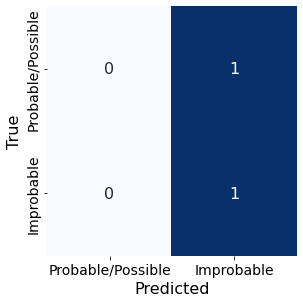

(<tensorflow.python.keras.engine.functional.Functional at 0x1f0edd898b0>,
 <tensorflow.python.keras.callbacks.History at 0x1ee491a0d90>)

In [33]:
trainModelWithDetailedMetrics(224, 'PrPo_Im', 1, 1)

In [9]:
'''Train the model'''
if NUM_CHANNEL == 1:
    train_array = np.array([np.expand_dims(x[0],axis=2) for x in train_data])
    validation_array = np.array([np.expand_dims(x[0],axis=2) for x in test_data])
elif NUM_CHANNEL == 3:
    train_array = np.array([x[0] for x in tr_data]) 
    train_array = np.moveaxis(train_array, 1, -1)
    validation_array = np.array([x[0] for x in te_data])
    validation_array = np.moveaxis(validation_array, 1, -1)

train_labels = np.array([x[1] for x in train_data])
validation_labels = np.array([x[1] for x in test_data])

In [14]:
'''Define performance metrics'''
#https://github.com/keras-team/keras/issues/5400#issuecomment-408743570
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
def plot_model_accuracy(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="lower right")
    plt.show()

def plot_model_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper right")
    plt.show()

In [13]:
"Define ResNet 50 model instance (Keras built-in)"
rn50 = resnet50.ResNet50(include_top=True, 
                           weights=None, 
                           input_tensor=None, 
                           input_shape=input_image_shape, 
                           pooling= 'max', 
                           classes=2)

rn50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
"Configure the model with losses and metrics"
rn50.compile(loss='categorical_crossentropy',  optimizer = "adam",
              metrics=[precision,recall, f1, 'accuracy']) 

start = timer()

"Fit ResNet 50 to data"
hist_rn50 = rn50.fit(
    train_array, train_labels, 
    batch_size = 32,
    epochs = 5,
    validation_data=(validation_array, validation_labels)
)

end = timer()
print(end - start)

Epoch 1/5
58/58 [==============================] - 163s 3s/step - loss: 0.5071 - precision: 0.9957 - recall: 0.9856 - f1: 0.9899 - accuracy: 0.9813 - val_loss: 0.9360 - val_precision: 0.7442 - val_recall: 1.0000 - val_f1: 0.8489 - val_accuracy: 0.7511
Epoch 2/5
58/58 [==============================] - 169s 3s/step - loss: 0.2499 - precision: 0.9928 - recall: 1.0000 - f1: 0.9963 - accuracy: 0.9928 - val_loss: 0.8423 - val_precision: 0.7442 - val_recall: 1.0000 - val_f1: 0.8489 - val_accuracy: 0.7511
Epoch 3/5
58/58 [==============================] - 170s 3s/step - loss: 0.0398 - precision: 0.9955 - recall: 1.0000 - f1: 0.9977 - accuracy: 0.9955 - val_loss: 0.9838 - val_precision: 0.7442 - val_recall: 1.0000 - val_f1: 0.8489 - val_accuracy: 0.7511
Epoch 4/5
58/58 [==============================] - 169s 3s/step - loss: 0.0285 - precision: 0.9964 - recall: 1.0000 - f1: 0.9982 - accuracy: 0.9964 - val_loss: 1.1521 - val_precision: 0.7442 - val_recall: 1.0000 - val_f1: 0.8489 - val_accuracy:

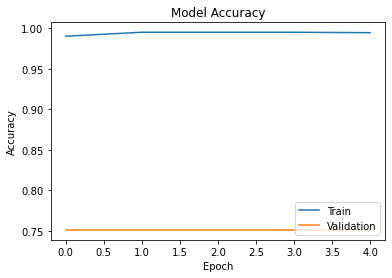

In [17]:
plot_model_accuracy(hist_rn50)

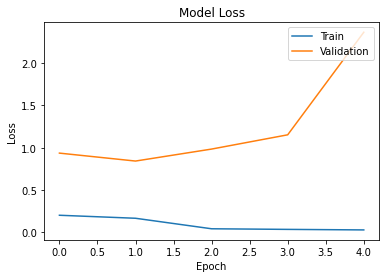

In [18]:
plot_model_loss(hist_rn50)

In [21]:
"""Instantiate the Inception v3 architecture"""
iv3 = tf.keras.applications.InceptionV3(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_image_shape,
    pooling='avg',
    classes=2,
    classifier_activation="softmax",
)

In [22]:
"Configure the model with losses and metrics"
iv3.compile(loss='categorical_crossentropy',  optimizer = "adam",
              metrics=[precision,recall, f1, 'accuracy']) 

start = timer()

"Fit Inception v3 to data"
hist_iv3 = iv3.fit(
    train_array, train_labels, 
    batch_size = 32,
    epochs = 10,
    validation_data=(validation_array, validation_labels)
)

end = timer()
print(end - start)

Epoch 1/10
58/58 [==============================] - 86s 1s/step - loss: 0.1988 - precision: 0.9968 - recall: 0.9303 - f1: 0.9481 - accuracy: 0.9271 - val_loss: 0.5612 - val_precision: 0.7442 - val_recall: 1.0000 - val_f1: 0.8489 - val_accuracy: 0.7511
Epoch 2/10
58/58 [==============================] - 80s 1s/step - loss: 0.0409 - precision: 0.9942 - recall: 1.0000 - f1: 0.9971 - accuracy: 0.9942 - val_loss: 0.8958 - val_precision: 0.7442 - val_recall: 1.0000 - val_f1: 0.8489 - val_accuracy: 0.7511
Epoch 3/10
58/58 [==============================] - 84s 1s/step - loss: 0.0392 - precision: 0.9943 - recall: 1.0000 - f1: 0.9971 - accuracy: 0.9943 - val_loss: 1.0684 - val_precision: 0.7442 - val_recall: 1.0000 - val_f1: 0.8489 - val_accuracy: 0.7511
Epoch 4/10
58/58 [==============================] - 88s 2s/step - loss: 0.0419 - precision: 0.9937 - recall: 0.9999 - f1: 0.9967 - accuracy: 0.9936 - val_loss: 1.3217 - val_precision: 0.7442 - val_recall: 1.0000 - val_f1: 0.8489 - val_accuracy:

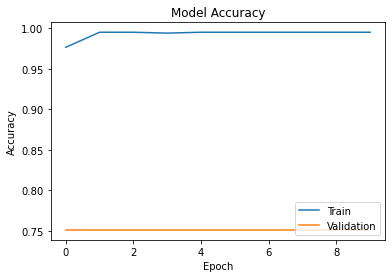

In [23]:
plot_model_accuracy(hist_iv3)

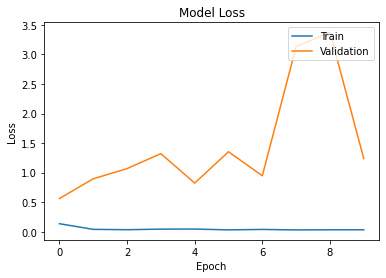

In [24]:
plot_model_loss(hist_iv3)